## **Import librairies**

In [79]:
# importation des differentes librairies
from sklearn import preprocessing
from sklearn.preprocessing import normalize, StandardScaler
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.svm          import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics      import f1_score, recall_score, accuracy_score, precision_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import gen_even_slices

pd.set_option("display.max_columns", 999)

## **Load data**

In [62]:
# Load data

file_dataset = f"Dataset"
file = "flights_sample_3m.csv"
path_dir = f"{file_dataset}\{file}"

df = pd.read_csv(path_dir)

display(df.head(3))

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",954,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Index', ylabel='Hour delay'>

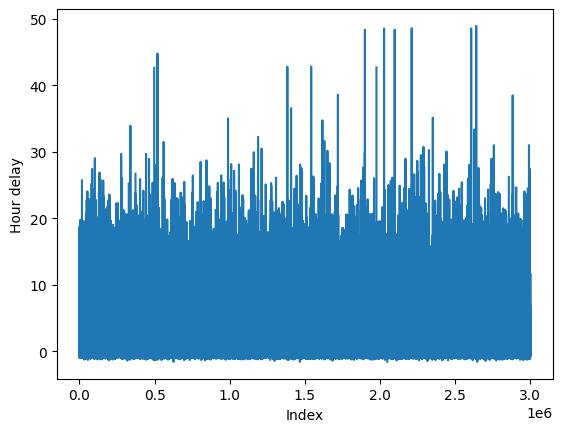

In [63]:
(df['ARR_DELAY']/60).plot( xlabel= 'Index', ylabel= 'Hour delay' )

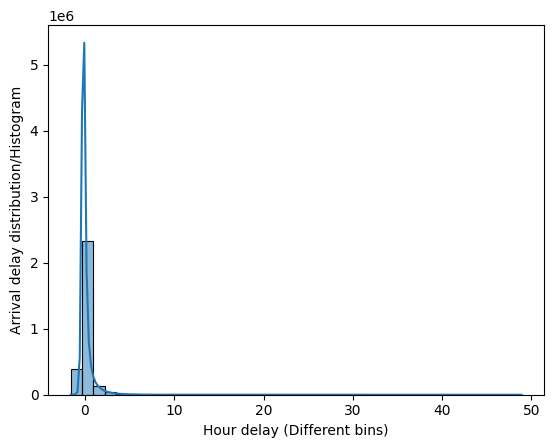

In [64]:
sns.histplot(df['ARR_DELAY']/60, bins=40, kde=True)
plt.ylabel('Arrival delay distribution/Histogram')
plt.xlabel('Hour delay (Different bins)')
plt.show()

#### Baseline

In [65]:
## Transformation of "CANCELLED" variable to make the cancellation as thousands hours delayed = 100.000 min
mask = df["CANCELLED"] == 1.0
df.loc[ mask , 'ARR_DELAY'] = 100000

display(df[mask].head(2))

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
14,2020-04-07,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,687,SJC,"San Jose, CA",LAX,"Los Angeles, CA",2155,NaN,NaN,NaN,NaN,NaN,NaN,2315,NaN,100000.0,1.0,D,0.0,80.0,NaN,NaN,308.0,NaN,NaN,NaN,NaN,NaN
45,2022-01-02,Republic Airline,Republic Airline: YX,YX,20452,3467,ORD,"Chicago, IL",DCA,"Washington, DC",1935,NaN,NaN,NaN,NaN,NaN,NaN,2241,NaN,100000.0,1.0,B,0.0,126.0,NaN,NaN,612.0,NaN,NaN,NaN,NaN,NaN


In [66]:
# drop Nan value
df.dropna(subset=['ARR_DELAY'], inplace=True)

In [67]:
# Time of arrival (HH) extraction
df['HOUR_SPLIT_ARR_CRS'] = df['CRS_ARR_TIME'].apply(
    lambda x: int(str(x)[:1]) if len(str(x)) <= 3 else int(str(x)[:2])
    ) # should be One hot encoded

In [68]:
# discritizing of arrival time
bins = [0 , 12 , 17 , np.inf]
labels = ['Morning 0-12', 'Afternoon 12-17', 'Night 17-24']

discritizier = preprocessing.FunctionTransformer(
             pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
             )
df['ARR_TYPE_HOUR_CRS'] = discritizier.fit_transform(df['HOUR_SPLIT_ARR_CRS']
                                                     )

In [69]:
# discritizing of arrival delays (THE NEW OUTPUT !!!)  - Class
bins = [-np.inf, -0.9999, 3 , 50 , np.inf]
labels = ['Early', 'Very Good', 'Bad', 'Cancelled']
discritizier = preprocessing.FunctionTransformer(
             pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
             )
df['ARR_TYPE_DELAY'] = discritizier.fit_transform(df['ARR_DELAY']/60) # conversion in hour

In [70]:
## Output Analysis
print(f"The number of occurrences of different classes :\n{df['ARR_TYPE_DELAY'].value_counts()} \n\nwhich means in %:\n{(df['ARR_TYPE_DELAY'].value_counts())/len(df)*100} ")


The number of occurrences of different classes :
Very Good    2880886
Cancelled      79140
Bad            32263
Early            653
Name: ARR_TYPE_DELAY, dtype: int64 

which means in %:
Very Good    96.255992
Cancelled     2.644221
Bad           1.077969
Early         0.021818
Name: ARR_TYPE_DELAY, dtype: float64 


In [71]:
# input and output splitting

y = df[['ARR_TYPE_DELAY']]
X = df[['AIRLINE_CODE' , 'ORIGIN' , 'DEST' , 'DISTANCE' ,  'ARR_TYPE_HOUR_CRS']] # 'HOUR_SPLIT_ARR_CRS' ,

print('\nInputs :\n')
display(X.head(10))

print('Outputs :\n')
display(y.head(10))


Inputs :



,AIRLINE_CODE,ORIGIN,DEST,DISTANCE,ARR_TYPE_HOUR_CRS
0,UA,FLL,EWR,1065.0,Afternoon 12-17
1,DL,MSP,SEA,1399.0,Night 17-24
2,UA,DEN,MSP,680.0,Morning 0-12
3,DL,MSP,SFO,1589.0,Night 17-24
4,NK,MCO,DFW,985.0,Night 17-24
5,WN,DAL,OKC,181.0,Morning 0-12
6,AA,DCA,BOS,399.0,Morning 0-12
7,YX,HSV,DCA,613.0,Night 17-24
8,NK,IAH,LAX,1379.0,Morning 0-12
9,AS,SEA,FAI,1533.0,Night 17-24


Outputs :



,ARR_TYPE_DELAY
0,Very Good
1,Very Good
2,Very Good
3,Very Good
4,Very Good
5,Very Good
6,Very Good
7,Very Good
8,Very Good
9,Very Good


In [74]:
# OHE of categorical features
nw_y = y.copy()
nw_X = pd.get_dummies(X)

print('Inputs :\n')
display(nw_X.head())

print('\nOutputs :\n')
display(nw_y.head())

Inputs :



,DISTANCE,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_G4,AIRLINE_CODE_HA,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OH,AIRLINE_CODE_OO,AIRLINE_CODE_QX,AIRLINE_CODE_UA,AIRLINE_CODE_WN,AIRLINE_CODE_YV,AIRLINE_CODE_YX,ORIGIN_ABE,ORIGIN_ABI,ORIGIN_ABQ,ORIGIN_ABR,ORIGIN_ABY,ORIGIN_ACK,ORIGIN_ACT,ORIGIN_ACV,ORIGIN_ACY,ORIGIN_ADK,ORIGIN_ADQ,ORIGIN_AEX,ORIGIN_AGS,ORIGIN_AKN,ORIGIN_ALB,ORIGIN_ALO,ORIGIN_ALS,ORIGIN_ALW,ORIGIN_AMA,ORIGIN_ANC,ORIGIN_APN,ORIGIN_ART,ORIGIN_ASE,ORIGIN_ATL,ORIGIN_ATW,ORIGIN_ATY,ORIGIN_AUS,ORIGIN_AVL,ORIGIN_AVP,ORIGIN_AZA,ORIGIN_AZO,ORIGIN_BDL,ORIGIN_BET,ORIGIN_BFF,ORIGIN_BFL,ORIGIN_BFM,ORIGIN_BGM,ORIGIN_BGR,ORIGIN_BHM,ORIGIN_BIH,ORIGIN_BIL,ORIGIN_BIS,ORIGIN_BJI,ORIGIN_BKG,ORIGIN_BLI,ORIGIN_BLV,ORIGIN_BMI,ORIGIN_BNA,ORIGIN_BOI,ORIGIN_BOS,ORIGIN_BPT,ORIGIN_BQK,ORIGIN_BQN,ORIGIN_BRD,ORIGIN_BRO,ORIGIN_BRW,ORIGIN_BTM,ORIGIN_BTR,ORIGIN_BTV,ORIGIN_BUF,ORIGIN_BUR,ORIGIN_BWI,ORIGIN_BZN,ORIGIN_CAE,ORIGIN_CAK,ORIGIN_CDB,ORIGIN_CDC,ORIGIN_CDV,ORIGIN_CGI,ORIGIN_CHA,ORIGIN_CHO,ORIGIN_CHS,ORIGIN_CID,ORIGIN_CIU,ORIGIN_CKB,ORIGIN_CLE,ORIGIN_CLL,ORIGIN_CLT,ORIGIN_CMH,ORIGIN_CMI,ORIGIN_CMX,ORIGIN_CNY,ORIGIN_COD,ORIGIN_COS,ORIGIN_COU,ORIGIN_CPR,ORIGIN_CRP,ORIGIN_CRW,ORIGIN_CSG,ORIGIN_CVG,ORIGIN_CWA,ORIGIN_CYS,ORIGIN_DAB,ORIGIN_DAL,ORIGIN_DAY,ORIGIN_DBQ,ORIGIN_DCA,ORIGIN_DDC,ORIGIN_DEC,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DHN,ORIGIN_DIK,ORIGIN_DLG,ORIGIN_DLH,ORIGIN_DRO,ORIGIN_DRT,ORIGIN_DSM,ORIGIN_DTW,ORIGIN_DVL,ORIGIN_EAR,ORIGIN_EAT,ORIGIN_EAU,ORIGIN_ECP,ORIGIN_EGE,ORIGIN_EKO,ORIGIN_ELM,ORIGIN_ELP,ORIGIN_ERI,ORIGIN_ESC,ORIGIN_EUG,ORIGIN_EVV,ORIGIN_EWN,ORIGIN_EWR,ORIGIN_EYW,ORIGIN_FAI,ORIGIN_FAR,ORIGIN_FAT,ORIGIN_FAY,ORIGIN_FCA,ORIGIN_FLG,ORIGIN_FLL,ORIGIN_FLO,ORIGIN_FNT,ORIGIN_FOD,ORIGIN_FSD,ORIGIN_FSM,ORIGIN_FWA,ORIGIN_GCC,ORIGIN_GCK,ORIGIN_GEG,ORIGIN_GFK,ORIGIN_GGG,ORIGIN_GJT,ORIGIN_GNV,ORIGIN_GPT,ORIGIN_GRB,ORIGIN_GRI,ORIGIN_GRK,ORIGIN_GRR,ORIGIN_GSO,ORIGIN_GSP,ORIGIN_GST,ORIGIN_GTF,ORIGIN_GTR,ORIGIN_GUC,ORIGIN_GUM,ORIGIN_HDN,ORIGIN_HGR,ORIGIN_HHH,ORIGIN_HIB,ORIGIN_HLN,ORIGIN_HNL,ORIGIN_HOB,ORIGIN_HOU,ORIGIN_HPN,ORIGIN_HRL,ORIGIN_HSV,ORIGIN_HTS,ORIGIN_HVN,ORIGIN_HYA,ORIGIN_HYS,ORIGIN_IAD,ORIGIN_IAG,ORIGIN_IAH,ORIGIN_ICT,ORIGIN_IDA,ORIGIN_ILG,ORIGIN_ILM,ORIGIN_IMT,ORIGIN_IND,ORIGIN_INL,ORIGIN_IPT,ORIGIN_ISN,ORIGIN_ISP,ORIGIN_ITH,ORIGIN_ITO,ORIGIN_JAC,ORIGIN_JAN,ORIGIN_JAX,ORIGIN_JFK,ORIGIN_JLN,ORIGIN_JMS,ORIGIN_JNU,ORIGIN_JST,ORIGIN_KOA,ORIGIN_KTN,ORIGIN_LAN,ORIGIN_LAR,ORIGIN_LAS,ORIGIN_LAW,ORIGIN_LAX,ORIGIN_LBB,ORIGIN_LBE,ORIGIN_LBF,ORIGIN_LBL,ORIGIN_LCH,ORIGIN_LCK,ORIGIN_LEX,ORIGIN_LFT,ORIGIN_LGA,ORIGIN_LGB,ORIGIN_LIH,ORIGIN_LIT,ORIGIN_LNK,ORIGIN_LRD,ORIGIN_LSE,ORIGIN_LWB,ORIGIN_LWS,ORIGIN_LYH,ORIGIN_MAF,ORIGIN_MBS,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MCW,ORIGIN_MDT,ORIGIN_MDW,ORIGIN_MEI,ORIGIN_MEM,ORIGIN_MFE,ORIGIN_MFR,ORIGIN_MGM,ORIGIN_MHK,ORIGIN_MHT,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MKG,ORIGIN_MLB,ORIGIN_MLI,ORIGIN_MLU,ORIGIN_MMH,ORIGIN_MOB,ORIGIN_MOT,ORIGIN_MQT,ORIGIN_MRY,ORIGIN_MSN,ORIGIN_MSO,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_MTJ,ORIGIN_MVY,ORIGIN_MYR,ORIGIN_OAJ,ORIGIN_OAK,ORIGIN_OGD,ORIGIN_OGG,ORIGIN_OGS,ORIGIN_OKC,ORIGIN_OMA,ORIGIN_OME,ORIGIN_ONT,ORIGIN_ORD,ORIGIN_ORF,ORIGIN_ORH,ORIGIN_OTH,ORIGIN_OTZ,ORIGIN_OWB,ORIGIN_PAE,ORIGIN_PAH,ORIGIN_PBG,ORIGIN_PBI,ORIGIN_PDX,ORIGIN_PGD,ORIGIN_PGV,ORIGIN_PHF,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_PIA,ORIGIN_PIB,ORIGIN_PIE,ORIGIN_PIH,ORIGIN_PIR,ORIGIN_PIT,ORIGIN_PLN,ORIGIN_PNS,ORIGIN_PPG,ORIGIN_PRC,ORIGIN_PSC,ORIGIN_PSE,ORIGIN_PSG,ORIGIN_PSM,ORIGIN_PSP,ORIGIN_PUB,ORIGIN_PUW,ORIGIN_PVD,ORIGIN_PVU,ORIGIN_PWM,ORIGIN_RAP,ORIGIN_RDD,ORIGIN_RDM,ORIGIN_RDU,ORIGIN_RFD,ORIGIN_RHI,ORIGIN_RIC,ORIGIN_RIW,ORIGIN_RKS,ORIGIN_RNO,ORIGIN_ROA,ORIGIN_ROC,ORIGIN_ROW,ORIGIN_RST,ORIGIN_RSW,ORIGIN_SAF,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_SAV,ORIGIN_SBA,ORIGIN_SBN,ORIGIN_SBP,ORIGIN_SCC,ORIGIN_SCE,ORIGIN_SCK,ORIGIN_SDF,ORIGIN_SEA,ORIGIN_SFB,ORIGIN_SFO,ORIGIN_SGF,ORIGIN_SGU,ORIGIN_SHD,ORIGIN_SHR,ORIGIN_SHV,ORIGIN_SIT,ORIGIN_SJC,ORIGIN_SJT,ORIGIN_SJU,ORIGIN_SLC,ORIGIN


Outputs :



,ARR_TYPE_DELAY
0,Very Good
1,Very Good
2,Very Good
3,Very Good
4,Very Good


In [76]:
X_train, X_test, y_train, y_test = train_test_split( nw_X, nw_y , test_size=0.10, random_state=42 , shuffle = True )

In [77]:
len(X_train)

2693647

In [78]:
len(X_test)

299295

In [80]:
## Cancellation baseline
n = 500

svm = SVC()

In [82]:
for i in list(gen_even_slices(len(X_train), n)):
  print(i)
  svm.fit(X_train[i], y_train[i])


slice(0, 5388, None)
slice(5388, 10776, None)
slice(10776, 16164, None)
slice(16164, 21552, None)
slice(21552, 26940, None)
slice(26940, 32328, None)
slice(32328, 37716, None)
slice(37716, 43104, None)
slice(43104, 48492, None)
slice(48492, 53880, None)
slice(53880, 59268, None)
slice(59268, 64656, None)
slice(64656, 70044, None)
slice(70044, 75432, None)
slice(75432, 80820, None)
slice(80820, 86208, None)
slice(86208, 91596, None)
slice(91596, 96984, None)
slice(96984, 102372, None)
slice(102372, 107760, None)
slice(107760, 113148, None)
slice(113148, 118536, None)
slice(118536, 123924, None)
slice(123924, 129312, None)
slice(129312, 134700, None)
slice(134700, 140088, None)
slice(140088, 145476, None)
slice(145476, 150864, None)
slice(150864, 156252, None)
slice(156252, 161640, None)
slice(161640, 167028, None)
slice(167028, 172416, None)
slice(172416, 177804, None)
slice(177804, 183192, None)
slice(183192, 188580, None)
slice(188580, 193968, None)
slice(193968, 199356, None)
slice(1

KeyboardInterrupt: 

In [ ]:
y_hat1 = svm.predict(X_test[0:n])

sc1 = f1_score(y_test[0:n], y_hat1, average='macro')
sc2 = recall_score(y_test[0:n], y_hat1, average='macro')
sc3 = accuracy_score(y_test[0:n], y_hat1)
sc4 = precision_score(y_test[0:n], y_hat1, average='macro')

score_svm = {
  'f1_score' : sc1  ,
  'recall_score' : sc2,
  'accuracy_score' : sc3,
  'precision_score' :sc4
}
print(f"{score_svm}")

In [ ]:
# Predictions
m = 50
hat = svm.predict(X_test[0:m])

out = {
      'Ground Truth' : list(y_test['ARR_TYPE_DELAY'][0:m] ) ,
      'Prediction' : list(hat)
  }

display(pd.DataFrame(out))
